In [1]:
from HW2 import CGS, MGS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

import ipywidgets as widgets
from ipywidgets import interact

# Orthogonality

We will begin with a demo of the style of visualization used throughout the rest of the notebook.
We will represent a collection of $M$ of vectors in $\mathbb{R}^N$ as a matrix in $\mathbb{R}^{M \times N}$, where each row is one of the vectors.
We will be illustrated the relationships between the vectors by computing $A A^*$, if $A$ is the matrix of vectors.
In this case, the diagonal will be the norms squared of the vectors themselves, while each other term represents the inner product between one vector and another.

In this first interactive plot, we are generating sets of `Number` vectors in a `Length` dimensional space.
Each vector is drawn i.i.d. according to a Gaussian distribution.

If you recall that independent, zero-mean random variables are orthogonal, then we would expect to see roughly a constant value on the diagonal, with nearly 0 values everywhere else - especially when the length parameter is high.

No need to write anything, but please just think conceptually about why this is the case.

In [2]:
@interact 
def plot_covariance(Length = (1,100,1), Number = (2,100,1)):
    data = np.random.randn(Number,Length)
    plt.imshow(np.matmul(data,np.transpose(data)))

interactive(children=(IntSlider(value=50, description='Length', min=1), IntSlider(value=51, description='Numbe…

# Gram-Schmidt

We will begin by visualizing the Gram-Schmidt process on some matrices.
The accuracy of Gram-Schmidt is heavily dependent on the condition number of the matrix containing the vectors.
In this notebook, we provide a function to generate a random matrix with a particular condition number.
We distribute the singular values in an exponential fashion between 1 and the inverse of the desired condition number.

In [3]:
def GenerateVectors(length, condition):
    [U, A] = np.linalg.qr(np.random.randn(length,length))
    [V, A] = np.linalg.qr(np.random.randn(length,length))
    D = np.diag(2.0**np.linspace(-np.log2(condition),0,length))
    mat = np.matmul(np.matmul(np.transpose(U),D),V)
    return mat

So now we'll look how your CGS and MGS implementations perform on ill-conditioned bases.
In the notes, we saw that even backwards stable algorithms will amplify errors as the product of a quantity known as $\epsilon_{\text{machine}}$ and the condition number.
First, let's get the value.
We will use a condition number inversely proportional to the machine epsilon.

In [4]:
eps = np.finfo(float).eps
condition_number = 1/eps

Now, let's generate a set of vectors using the above function and check the orthogonality

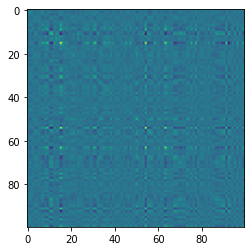

In [5]:
mat = GenerateVectors(100,condition_number)
plt.imshow(np.matmul(mat,np.transpose(mat)));

It's very easy to see that it isn't particularly orthogonal, there is quite a bit of structure to the set.
We will now apply the classical algorithm to orthonormalize.

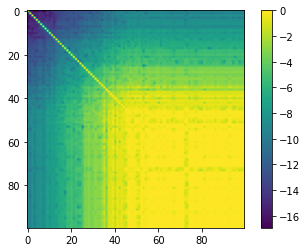

In [6]:
ortho = CGS(mat) # Orthonormalize
# Plot on magnitude of inner product on a log scale
plt.imshow(np.log10(np.abs(np.matmul(ortho,np.transpose(ortho)))))
plt.colorbar();
plt.savefig("CGS_ortho.png")

So what happened halfway through? The vectors stopped being orthogonal!
Please submit the above plot in the homework.

Let's look at a pair of vectors late in the process.
We'll see that the floating-point errors produced nearly identical vectors, which is kind of neat.
If the errors were random and independent, we would have expected to get something closer to orthogonality like in the original interactive plot.

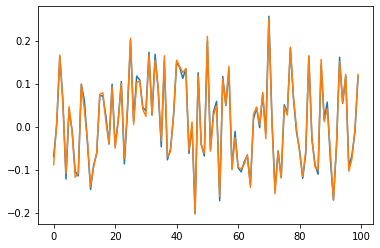

In [7]:
plt.plot(ortho[-1,:])
plt.plot(ortho[-2,:])

Now let's try applying the modified algorithm.
Remember, some of the floating point error get removed in later projections.

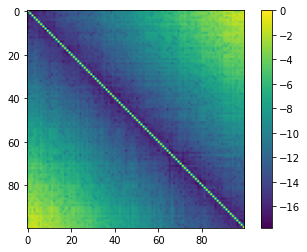

In [8]:
ortho = MGS(mat);
plt.imshow(np.log10(np.abs(np.matmul(ortho,np.transpose(ortho)))))
plt.colorbar();
plt.savefig("MGS_ortho.png")

So in this plot, we see that we begin to lose some orthogonality between the beginning and the end of the process, but the results are overall much better.
Please include the above plot.

If we the first and the last vector, which seem to be the least orthogonal, we that while they appear much less similar than the previous pair of vectors.

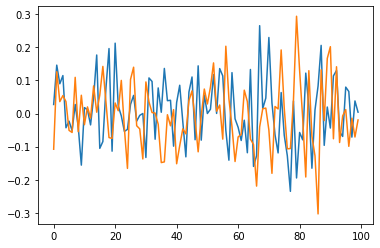

In [9]:
plt.plot(ortho[0,:]);
plt.plot(ortho[-1,:]);

Finally, it is worth noting that QR factorization produces an orthonormal basis, and uses a more numerically stable algorithm than either of the two discussed here. We illustrate it below.

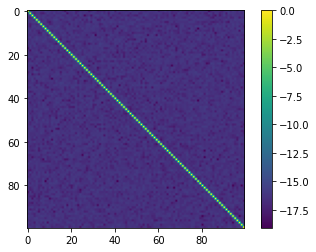

In [10]:
[ortho,A] = np.linalg.qr(mat);
plt.imshow(np.log10(np.abs(np.matmul(ortho,np.transpose(ortho)))))
plt.colorbar();

# Orthonormal Image Basis

There is a small amount of code for you to complete in this section.

In this section, we will look at applying the algorithm to a vector space of images to generate a random, but structured orthonormal basis.
You will then project any image that you would like onto the space.
This section of the assignment is modified from fall 2018.

You can either use your own favorite image, or the copy of one of your TA's favorite images provided.

In [11]:
def RandomDisk(width,height, radius):
    """ Generate an image of given dimensions with
    a single randomly placed disk of a given radius."""
    out = np.zeros((width,height))
    center = [np.random.randint(radius,height-radius), np.random.randint(radius,width-radius)]
    columns, rows = np.mgrid[0:width, 0:height]
    mask = (rows-center[0])**2 + (columns-center[1])**2 <= radius**2
    return 1*mask #convert to integer

Running the above function generates a random disk, we will make an orthonormal basis of shapes based on disks like the following.

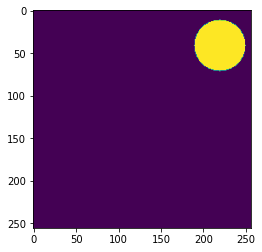

In [12]:
plt.imshow(RandomDisk(256,256,30));

In the next cell, import your favorite (low resolution) image, or use the provided test image.

If you use a different image, please include it in the homework writeup.

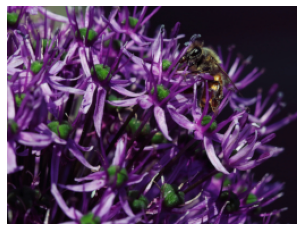

In [13]:
test_image_color = image.imread("TestImage.JPG")
img_width = test_image_color.shape[0]
img_height = test_image_color.shape[1]
plt.imshow(test_image_color)
plt.axis('off');

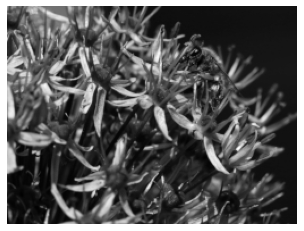

In [14]:
# Convert to Grayscale
test_image = np.sum(test_image_color,axis=2).astype(float)
plt.imshow(test_image,cmap="gray")
plt.axis('off');

We will now generate a basis of disks for some random subspace of images of the given resolution.
The code below takes a given number of basis vectors, and chooses an appropriate radius for the disks.

Hopefully 100 works for people, higher numbers will give a better representation of the image, while lower numbers will run faster.
Try out some different values.

In [15]:
# Generate a list of random disks
disk_num = 1000
disk_radius = int(np.sqrt(img_width*img_height / disk_num))
basis = [RandomDisk(img_width,img_height,disk_radius) for i in range(disk_num)];

In order to apply our algorithm to the image, we flatten our images into the matrix form, constructing a very wide, but short matrix.

In [16]:
# Flatten
full_length = img_width*img_height
A = np.zeros((disk_num,full_length));
for i in range(disk_num):
    A[i,:] = np.reshape(basis[i], full_length)

At this point, we will apply our MGS function to orthogonalize the disks.

In [17]:
ortho_basis = MGS(A)

Now let's visualize one of the disks.
To do this, we reshape the vector back into an image.
With a little luck, you should get something that, in some sense, decays progressively from a point (in a blocky fashion).

Please include the plot below.

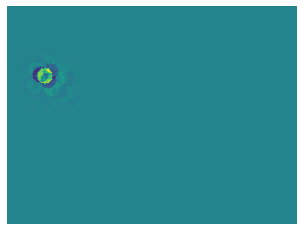

In [18]:
plt.imshow(np.reshape(ortho_basis[-1,:],(img_width,img_height)))
plt.axis('off')
plt.imsave("BasisVector.png",np.reshape(ortho_basis[-1,:],(img_width,img_height)))

Now we project our image onto the *orthonormal basis*. Recall the projection operator from lecture.

We finally rescale the image values to \[0,1\]

In [19]:
# Project onto the Basis
projection = np.matmul(np.transpose(ortho_basis),np.matmul(ortho_basis,np.reshape(test_image,full_length)))
filtered = np.reshape(projection,(img_width,img_height))

# Rescale to correct range
filtered -= np.min(filtered)
filtered /= np.max(filtered)

Now let's see the approximation that we created.
Please include the below image in your writeup.

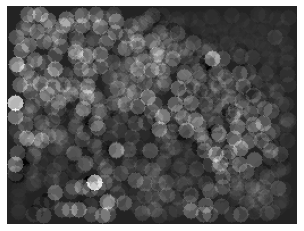

In [20]:
plt.imshow(filtered,cmap='gray')
plt.axis('off')
plt.imsave("BWImage.png",filtered,cmap='gray')

Unfortunately, the provided test image isn't very interesting in grayscale under these projections.

Try applying the basis to the original color image. No need to generate the basis again, just follow the procedure for each channel (RGB) of the image seperately.

Include the color version in the writeup.

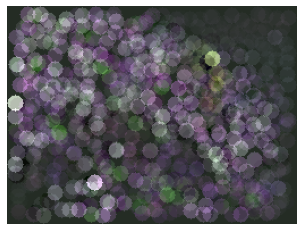

In [21]:
## Your code here ##
def project_channel(channel):
    projection = ortho_basis.T @ (ortho_basis @ channel.flatten())
    projection -= projection.min()
    projection /= projection.max()
    return np.reshape(projection, channel.shape)

img_r = project_channel(test_image_color[..., 0])
img_g = project_channel(test_image_color[..., 1])
img_b = project_channel(test_image_color[..., 2])

img_rgb = np.stack([img_r, img_g, img_b], axis=-1)
plt.imshow(img_rgb)
plt.axis('off')
plt.imsave("ColorImage.png",img_rgb)